In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

import umap
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)

from scipy.stats import chi2, linregress
from scipy.stats.mstats import winsorize

from collections import Counter

# For Alpaca API
from datetime import datetime
from zoneinfo import ZoneInfo

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.stock import StockHistoricalDataClient

from alpaca.data.requests import (
    StockBarsRequest
)

from alpaca.data.enums import Adjustment

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

# For API Keys
import os
from dotenv import load_dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [36]:
ticker_subsets = {
    'US_Equity': ['SPY', 'QQQ', 'IWM', 'DIA'],
    'Defensive_Sectors': ['XLP', 'XLV', 'XLU'],
    'Global_Equities': ['EEM', 'EFA', 'FXI', 'EWZ'],
    'Currencies': ['UUP', 'FXY', 'FXF', 'FXE', 'FXA', 'FXC']
}

all_tickers = sum(ticker_subsets.values(), [])

In [37]:
# Alpaca Data Load
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016
earliest_date = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
last_date = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

req = StockBarsRequest(
    symbol_or_symbols = all_tickers, 
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,  
    end = last_date,                  
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [38]:
print("Total NANs:", df_adj.pivot(columns="symbol").isna().sum().sum())

Total NANs: 0


In [39]:
# Trend feature functions
def compute_trend_features(df):
    df = df.sort_index()
    df['ret_5d'] = df['close'].pct_change(5)
    df['ret_20d'] = df['close'].pct_change(20)
    df['ma_200'] = df['close'].rolling(200).mean()
    df['rsi_14'] = compute_rsi(df['close'], 14)
    return df

def compute_rsi(series, period):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(com=period - 1, min_periods=period).mean()
    ma_down = down.ewm(com=period - 1, min_periods=period).mean()
    rs = ma_up / ma_down
    return 100 - (100 / (1 + rs))

# Apply feature extraction
features_by_subset = {}
for subset, tickers in ticker_subsets.items():
    df_subset = df_adj[df_adj['symbol'].isin(tickers)].copy()
    df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
    df_feat = df_feat.droplevel(0)  # remove groupby index level
    df_feat = df_feat.dropna()
    features_by_subset[subset] = df_feat

C:\Users\sergi\AppData\Local\Temp\ipykernel_14220\958094803.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
C:\Users\sergi\AppData\Local\Temp\ipykernel_14220\958094803.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
C:\Users\sergi\AppData\Local\Temp\ipykernel_14220\95809480

In [40]:
# Combine all subsets
df_all = pd.concat(features_by_subset.values(), axis=0)
df_all = df_all.sort_index()

# Pivot wide
pivot_cols = ['ret_5d', 'ret_20d', 'rsi_14']
df_pivot = df_all.pivot_table(index=df_all.index, columns='symbol', values=pivot_cols)
df_pivot = df_pivot.dropna()

# Final smoothed 10 features
df_features = pd.DataFrame(index=df_pivot.index)

# 1. Mean 5-day return across equity indices
df_features['us_equity_returns_5d_avg'] = df_pivot['ret_5d'][['SPY', 'QQQ', 'IWM', 'DIA']].mean(axis=1)


# 2. US Equity Indices momentum slope: slope of 10-day returns linear fit
def slope_of_returns(series):
    x = np.arange(len(series))
    if len(series) < 10 or series.isnull().any():
        return np.nan
    slope, _, _, _, _ = linregress(x, series)
    return slope

eq_mom_slope = pd.DataFrame(index=df_pivot.index)
for c in ['SPY', 'QQQ', 'IWM', 'DIA']:
    eq_mom_slope[c] = df_pivot['ret_5d'][c].rolling(window=10).apply(slope_of_returns, raw=False)

df_features['us_equity_momentum_slope'] = eq_mom_slope.mean(axis=1)

# 3. Defensive sector RSI difference: mean RSI of defensive sectors minus mean RSI of US and global equity indices
df_features['equity_defensive_vs_broad_rsi_14d_spread'] = df_pivot['rsi_14'][['XLP', 'XLV', 'XLU']].mean(axis=1) -\
                                  df_pivot['rsi_14'][['SPY', 'QQQ', 'IWM', 'DIA', 'EEM', 'EFA', 'FXI', 'EWZ']].mean(axis=1)

# 4. Global mean RSI across global equities (smooth replacement)
df_features['global_equity_rsi_14d_avg'] = df_pivot['rsi_14'][['EEM', 'EFA', 'FXI', 'EWZ']].mean(axis=1)

# 5. Defensive safe-haven currencies against more cyclically-oriented "risk-on" currencies
df_features['safe_vs_risk_currencies_returns_5d_spread'] = df_pivot['ret_20d'][['UUP', 'FXY', 'FXF']].mean(axis=1) - \
                                      df_pivot['ret_20d'][['FXE', 'FXA', 'FXC']].mean(axis=1)

# Drop any rows with NaNs introduced by rolling window
df_features = df_features.dropna()

# Updated final features dataframe
df_pivot_clean = df_features.copy()

In [41]:
# clip 1% and 99% quantiles to reduce outliers
for col in df_pivot_clean.columns:
    # Winsorize at the 0+limit% and 100-limit% quantiles
    df_pivot_clean[col] = winsorize(df_pivot_clean[col], limits=[0.01, 0.01])

In [42]:
N_COMP=3
N_NEIG=15
MIN_D = 0.01
METRIC = "correlation" 
K = 4

RANDOM_STATE = 4

In [43]:
scaled = StandardScaler().fit_transform(df_pivot_clean)
X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC, random_state=RANDOM_STATE).fit_transform(scaled)

gmm = GaussianMixture(n_components=K, init_params="k-means++", random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(X_umap)

print({
    "silhouette": silhouette_score(X_umap, gmm_labels),
    "calinski_harabasz": calinski_harabasz_score(X_umap, gmm_labels),
    "davies_bouldin": davies_bouldin_score(X_umap, gmm_labels)
})

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'silhouette': 0.4296022653579712, 'calinski_harabasz': 2093.04248046875, 'davies_bouldin': 0.8418993589670372}


In [44]:
# ## Save scaler, umap, and gmm model
# import joblib

# # Define model directory
# MODEL_DIR = "models"
# os.makedirs(MODEL_DIR, exist_ok=True)

# # Save the scaler
# scaler = StandardScaler().fit(df_pivot_clean)
# joblib.dump(scaler, os.path.join(MODEL_DIR, "trend_scaler.pkl"))

# # Save the fitted UMAP model
# umap_model = umap.UMAP(
#     n_neighbors=N_NEIG,
#     min_dist=MIN_D,
#     n_components=N_COMP,
#     metric=METRIC,
#     random_state=RANDOM_STATE
# ).fit(scaled)
# joblib.dump(umap_model, os.path.join(MODEL_DIR, "trend_umap_model.pkl"))

# # Save the trained GMM model
# joblib.dump(gmm, os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))


In [45]:
# Define colors for plots
accent_colors = plt.cm.Accent(np.linspace(0, 1, K))
custom_cmap = "Accent"
cluster_palette = {i: accent_colors[i] for i in range(K)}

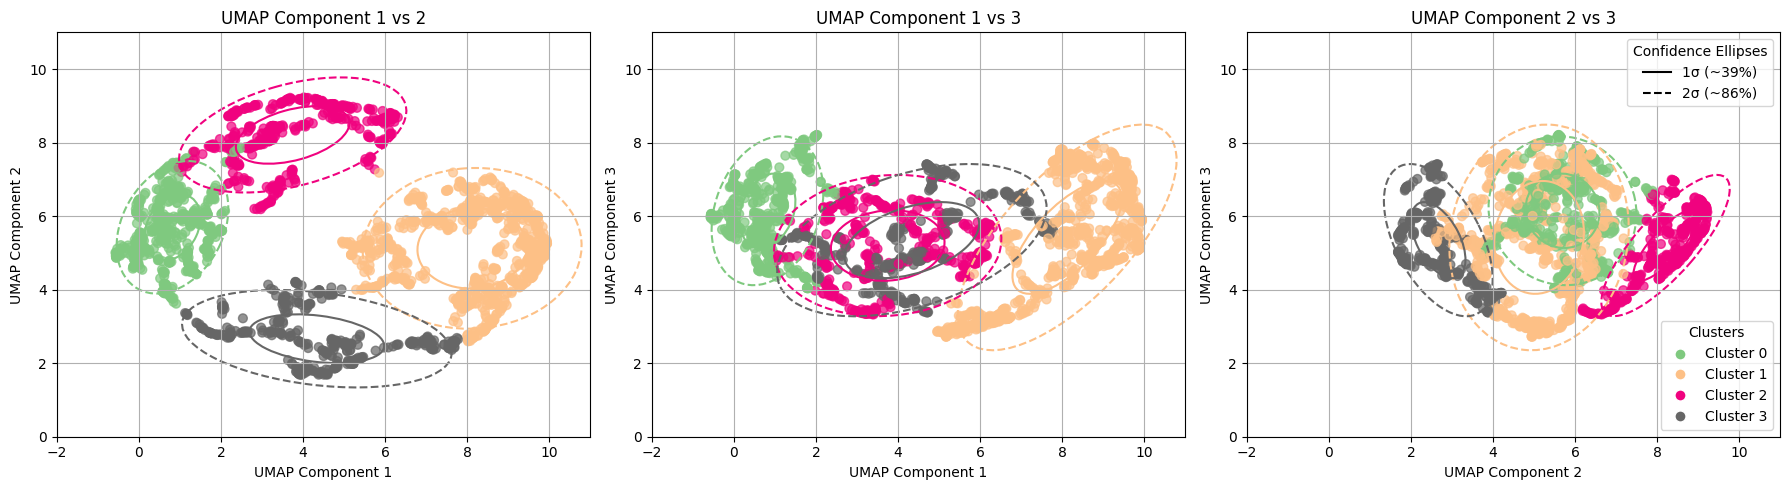

In [46]:
# Define component pairs for plotting
component_pairs = [(0, 1), (0, 2), (1, 2)]
titles = [
    "UMAP Component 1 vs 2",
    "UMAP Component 1 vs 3",
    "UMAP Component 2 vs 3"
]

def plot_gmm_std_ellipses(ax, gmm, comp_x, comp_y, colors):

    std_levels = [1, 2]
    chi2_vals = [chi2.ppf(0.3935, df=2), chi2.ppf(0.8647, df=2)]
    scales = [np.sqrt(val) for val in chi2_vals]

    for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
        if covar.ndim == 1:  # spherical
            cov = np.diag(covar)
        elif covar.ndim == 2:  # full or tied
            cov = covar
        else:
            continue

        # Project to 2D
        sub_cov = cov[np.ix_([comp_x, comp_y], [comp_x, comp_y])]
        sub_mean = mean[[comp_x, comp_y]]

        # Eigen decomposition
        vals, vecs = np.linalg.eigh(sub_cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        for scale, std in zip(scales, std_levels):
            width, height = 2 * scale * np.sqrt(vals)

            if std == 1:
                linestyle = '-'
            elif std == 2:
                linestyle = '--'
            else:
                linestyle = ':'

            ellipse = Ellipse(
                sub_mean, width, height, angle=theta,
                edgecolor=colors[i], facecolor='none', lw=1.5, linestyle=linestyle
            )
            ax.add_patch(ellipse)

# round the global min and max to the upper/lower integers, so all plot have the same limits
x_vals = []
y_vals = []
for comp_x, comp_y in component_pairs:
    x_vals.extend(X_umap[:, comp_x])
    y_vals.extend(X_umap[:, comp_y])
x_min, x_max = min(x_vals), max(x_vals)
y_min, y_max = min(y_vals), max(y_vals)
# Round to nearest  boundaries
x_min = np.floor(x_min) -1
x_max = np.ceil(x_max) +1
y_min = np.floor(y_min) -1
y_max = np.ceil(y_max) +1

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (comp_x, comp_y) in enumerate(component_pairs):
    ax = axes[i]
    scatter = ax.scatter(
        X_umap[:, comp_x], X_umap[:, comp_y],
        c=gmm_labels, cmap=custom_cmap, s=40, alpha=0.7
    )
    ax.set_xlabel(f'UMAP Component {comp_x + 1}')
    ax.set_ylabel(f'UMAP Component {comp_y + 1}')
    ax.set_title(titles[i])
    ax.grid(True)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Plot GMM ellipses
    plot_gmm_std_ellipses(ax, gmm, comp_x, comp_y, accent_colors)

# Add legend to the last plot
custom_lines = [
    Line2D([0], [0], color='black', lw=1.5, linestyle='-'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--'),
    Line2D([0], [0], color='black', lw=1.5, linestyle=':')
]
confidence_legend = axes[-1].legend(custom_lines, ['1σ (~39%)', '2σ (~86%)'], loc="upper right", title="Confidence Ellipses")

# Add first legend for confidence ellipses
axes[-1].add_artist(confidence_legend) 

# Create second legend for clusters
cluster_handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=accent_colors[i], markersize=8)
    for i in range(K)
]
cluster_legend = axes[-1].legend(handles=cluster_handles, loc='lower right', title="Clusters")


plt.tight_layout()
plt.show()

In [47]:
# Print percentage of data points in each cluster
cluster_counts = pd.Series(gmm_labels).value_counts(normalize=True) * 100
print("\n Percentage of data points in each cluster:")
for cluster_id, percentage in cluster_counts.sort_index().items():
    print(f"Cluster {cluster_id}: {percentage:.2f}%")


 Percentage of data points in each cluster:
Cluster 0: 23.43%
Cluster 1: 38.29%
Cluster 2: 20.04%
Cluster 3: 18.25%


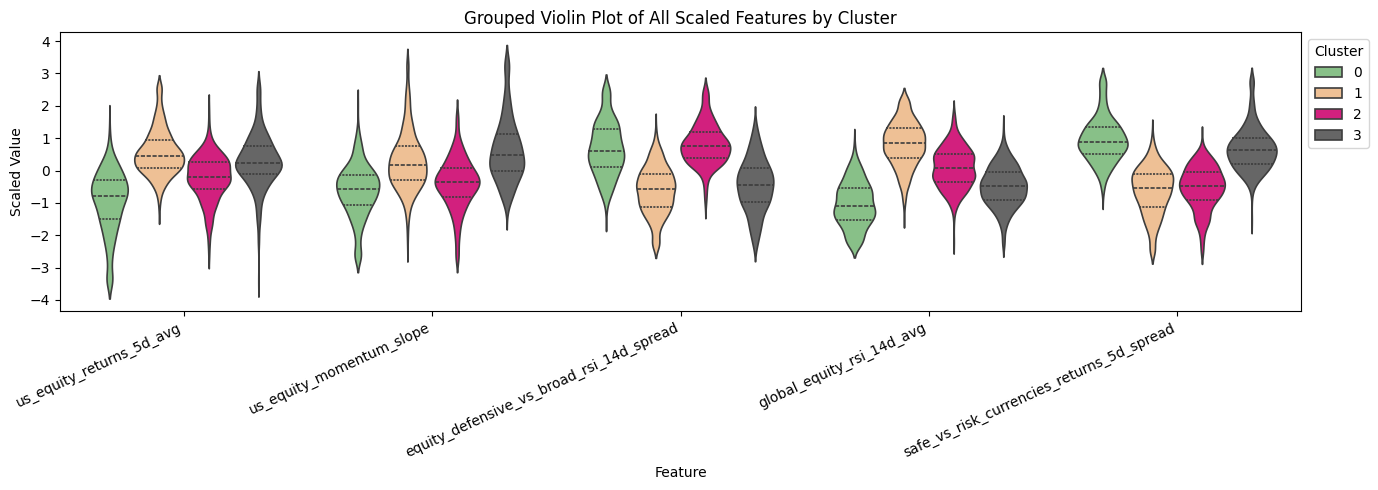

In [48]:
df_interpret = pd.DataFrame(scaled, columns=df_pivot_clean.columns, index=df_pivot_clean.index)
# Assign cluster labels
df_interpret['Cluster'] = gmm_labels

# Melt the dataframe to long format for seaborn
df_melted = df_interpret.reset_index().melt(id_vars=['Cluster'], 
                                              value_vars=df_interpret.columns,
                                              var_name='Feature', 
                                              value_name='Scaled Value')
# Create grouped violin plot
plt.figure(figsize=(14, 5))
sns.violinplot(
    data=df_melted,
    x='Feature',
    y='Scaled Value',
    hue='Cluster',
    palette=cluster_palette,
    split=False,        # Merge both clusters' violins in one shape if applicable
    inner='quartile',  # Show quartiles instead of full box
    linewidth=1.2
)

plt.title('Grouped Violin Plot of All Scaled Features by Cluster')
plt.ylabel('Scaled Value')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()


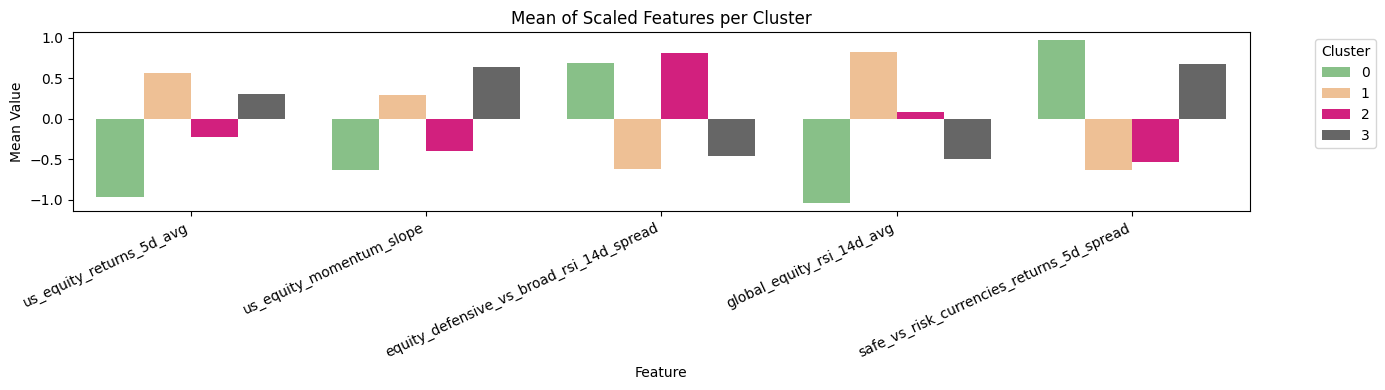

In [ ]:
# Calculate mean value per feature per cluster
mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(14, 4))
sns.barplot(x='Feature', y='Mean', hue='Cluster', data=melted, palette=cluster_palette)

plt.title('Mean of Scaled Features per Cluster')
plt.ylabel('Mean Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()

# 0 green "Bear" 
# 1 yellow "Bull" 
# 2 pink neutral-bearish US, global neutral, high defensive, low currency defensive (weak dollar)
# 3 grey bull US, strong momentum us, low defensive, bearish global, high currency defensive (strong dollar)

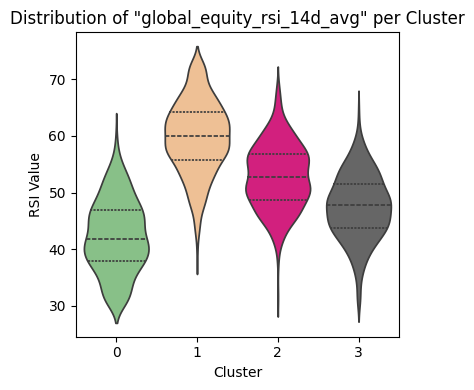

In [50]:
# To interpret RSI: must be no scaled
# RSI (Relative Strength Index) is a momentum oscillator that measures the speed and change of price

# RSI above 50 suggests bullish momentum; below 50 suggests bearish momentum.

# RSI > 70 → Asset may be overbought (potential for a price drop).
# RSI < 30 → Asset may be oversold (potential for a price rise).

# Limitations of RSI
# False Signals: Especially in trending markets, RSI can stay in overbought/oversold zones for extended periods.
# Lagging Indicator: RSI reflects past price action, not future movement.

df_interpret_no_sca = pd.DataFrame(df_pivot_clean, columns=df_pivot_clean.columns, index=df_pivot_clean.index)
df_interpret_no_sca['Cluster'] = gmm_labels

plt.figure(figsize=(4, 4))
sns.violinplot(
    x='Cluster',
    y='global_equity_rsi_14d_avg',
    hue='Cluster',  # Explicitly assign hue
    data=df_interpret_no_sca,
    palette=cluster_palette,
    inner='quartile',
    legend=False    # Prevent duplicate legend
)

plt.title(f'Distribution of \"{'global_equity_rsi_14d_avg'}\" per Cluster')
plt.xlabel('Cluster')
plt.ylabel('RSI Value')
plt.tight_layout()
plt.show()

In [51]:
req = StockBarsRequest(
    symbol_or_symbols = 'SPY',
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date, 
    end = last_date,                                     
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_2_plot = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_2_plot = df_2_plot.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs
# remove first days that do not have cluster
df_2_plot =  df_2_plot[len(df_2_plot)-len(df_pivot_clean):]

# Merge cluster labels into df_2_plot
df_with_clusters = df_2_plot.copy()
# Prepare the dataframe with timestamp index and cluster labels
df_time_clustered = df_pivot_clean.copy()
df_time_clustered['Cluster'] = gmm_labels
df_time_clustered = df_time_clustered.sort_index()  # Ensure it's sorted by time

df_with_clusters['Cluster'] = df_time_clustered.loc[df_2_plot.index, 'Cluster'].values

In [52]:
# 5-day majority vote smoothing, reduces noise, more interpretable and realistic
def rolling_mode(series):
    """Returns the most frequent value in the window."""
    counts = Counter(series)
    return counts.most_common(1)[0][0]

def smooth_clusters(cluster_series, window):
    return cluster_series.rolling(window=window, center=True).apply(rolling_mode, raw=True)

WINDOW_SMOOTH = 5 # regime can change very fast, 5 days is the sweet spot, 3 too small, 7 too large

df_with_clusters['cluster_smooth'] = smooth_clusters(df_with_clusters['Cluster'], window=WINDOW_SMOOTH)
# fill NaNs (first and last days are nans because of the center=true window)
# fill with forward values in the first days, backward in last days. Best solution for post ML models
df_with_clusters['cluster_smooth'] = df_with_clusters['cluster_smooth'].ffill().bfill().astype(int)

In [53]:
# Compare cluster assignment agreement
print("\nAgreement smooth clustering vs original clustering")
(df_with_clusters['Cluster'] == df_with_clusters['cluster_smooth']).value_counts(normalize=True)


Agreement smooth clustering vs original clustering


True     0.901421
False    0.098579
Name: proportion, dtype: float64

In [54]:
# Print percentage of data points in each cluster
cluster_counts_smooth = df_with_clusters['cluster_smooth'].value_counts(normalize=True) * 100
cluster_counts_smooth_diff = cluster_counts_smooth - cluster_counts
print("\nDifference in Percentage of data points in each cluster, smooth - normal:")
for cluster_id, percentage in cluster_counts_smooth_diff.sort_index().items():
    print(f"Cluster {cluster_id}: {percentage:.2f}%")


Difference in Percentage of data points in each cluster, smooth - normal:
Cluster 0: 0.55%
Cluster 1: 1.33%
Cluster 2: -1.19%
Cluster 3: -0.69%


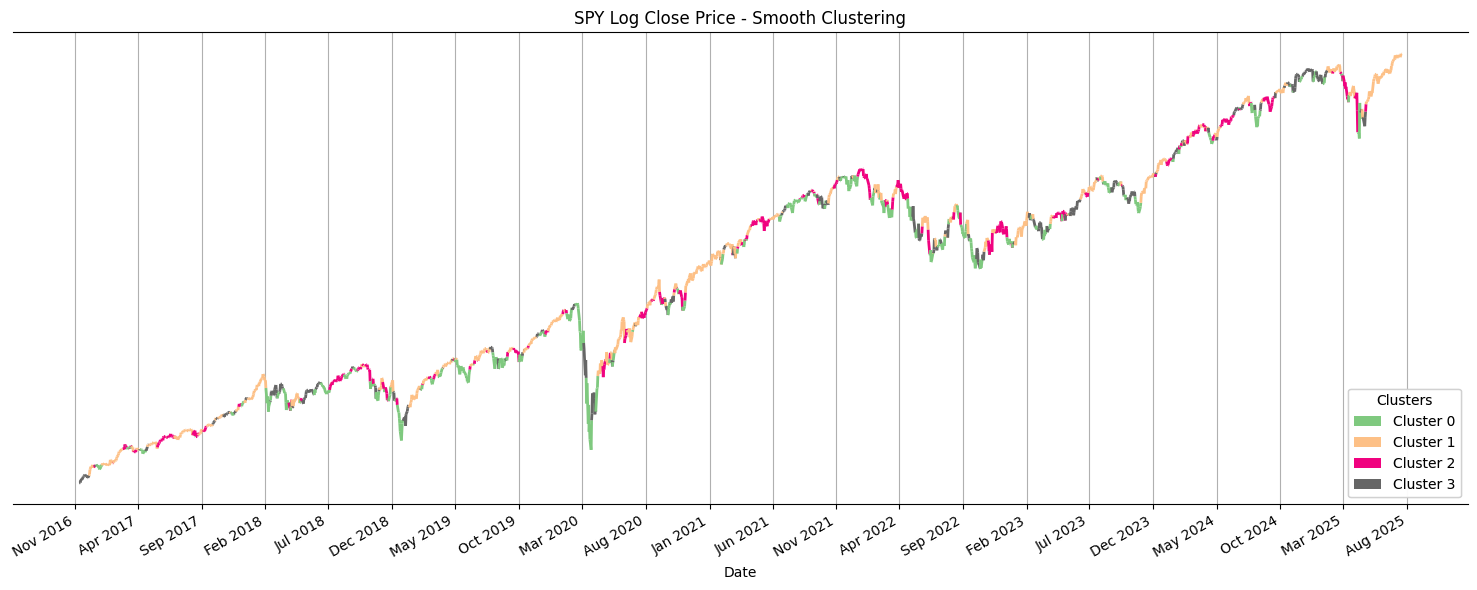

In [55]:
# Prepare data for colored line segments
dates = df_with_clusters.index
close_prices = np.log(df_with_clusters['close'].values)
clusters = df_with_clusters['Cluster'].values

# Prepare data for original line
dates = df_with_clusters.index
date_nums = mdates.date2num(dates)

# Scaled log close price
close_prices_scaled = np.log(df_with_clusters['close'].values)
clusters_smooth = df_with_clusters['cluster_smooth'].values

# Create line segments for original line
points = np.array([date_nums, close_prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize cluster values
norm = plt.Normalize(min(clusters_smooth), max(clusters_smooth))

# Colormap
cmap = plt.get_cmap(custom_cmap)

# LineCollection for original line
lc1 = LineCollection(segments, cmap=cmap, norm=norm)
lc1.set_array(clusters[:-1])
lc1.set_linewidth(2)


# Plot both lines
fig, ax = plt.subplots(figsize=(15, 6))
ax.add_collection(lc1)
ax.autoscale()
ax.set_title("SPY Log Close Price - Smooth Clustering")
ax.set_xlabel("Date")

# Remove y-axis
ax.set_ylabel("")
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(True)

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

# Legend for original clusters
unique_clusters1 = np.unique(clusters)
legend_elements1 = [Patch(facecolor=cmap(norm(c)), label=f'Cluster {c}') for c in unique_clusters1]
legend1 = ax.legend(handles=legend_elements1, loc="lower right", title="Clusters")
ax.add_artist(legend1)  # Add first legend manually


plt.tight_layout()
plt.show()


In [56]:
# SPY close es lo mejor para ver esto?

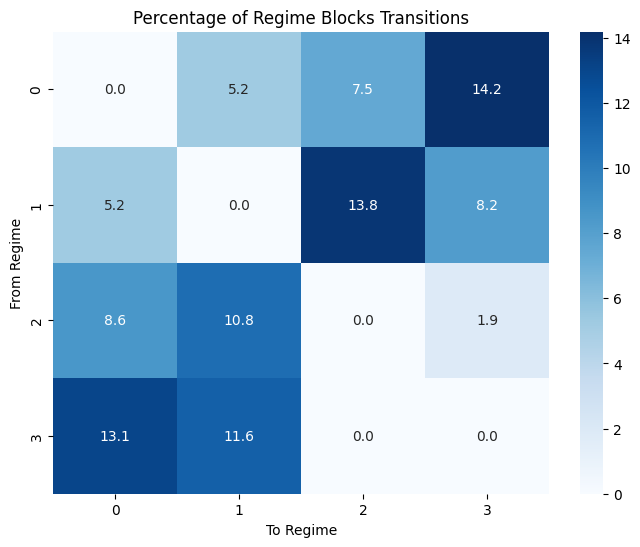

In [ ]:
## Regime Block Transitions
# [0, 0, 0, 1, 1, 0, 0, 2, 2, 2] -> [0, 1, 0, 2]

# Extract the column
cluster_series = df_with_clusters['cluster_smooth']

# Keep only the first occurrence of each block
regime_blocks = cluster_series[cluster_series.shift() != cluster_series].reset_index(drop=True)

# Create transition pairs
transitions = list(zip(regime_blocks[:-1], regime_blocks[1:]))

# Count transitions
transition_counts = pd.Series(transitions).value_counts().sort_index()

# Convert to DataFrame
transition_df = transition_counts.reset_index()
transition_df.columns = ['from_to', 'count']
transition_df['from'] = transition_df['from_to'].apply(lambda x: x[0])
transition_df['to'] = transition_df['from_to'].apply(lambda x: x[1])

# Calculate percentage
total_transitions = transition_df['count'].sum()
transition_df['percentage'] = 100 * transition_df['count'] / total_transitions

# Pivot for heatmap
heatmap_data = transition_df.pivot(index='from', columns='to', values='percentage').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Blues")
plt.title("Percentage of Regime Blocks Transitions")
plt.xlabel("To Regime")
plt.ylabel("From Regime")
plt.show()

# este es el mejor grafico para lo que quieres? seguro que renta por blocks y no todo raw?
